In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
from statistics_methods.Statistics import StatisticsWrapper
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import pandas as pd
from sdv.metadata import SingleTableMetadata
import sdv
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity
from statistics_methods.plots import PlotsManager
import matplotlib.pyplot as plt
import numpy as np


In [3]:
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS

In [94]:
def load_data(data_path, outliers=[]):
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]
    # chosen_data = chosen_data.drop(columns=constants.SLOPES)
    chosen_data['ROI'] = chosen_data['ROI'].astype(int)
    chosen_data['subjects'] = chosen_data['subjects'].astype(str)

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects

In [5]:
outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB']
# outliers = []
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(constants.PATH_TO_CORTEX_all_params_raw, outliers=outliers)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(constants.PATH_TO_CORTEX_all_params_z_score, outliers=outliers)

# Cortex

In [86]:
def show_correlations_stats(all_data, young_data, old_data, method):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single',
                                                                title="all")['dendrogram_data']['ivl']
    young_result = StatisticsWrapper.roi_correlations(young_data, params_to_work_with, clusters_rois,
                                                        group_title='Correlations of young group', method=method)
    old_result = StatisticsWrapper.roi_correlations(old_data, params_to_work_with, clusters_rois,
                                                     group_title='Correlations of old group', method=method)
                        
    young_corr_means, old_corr_means  = show_corr_mean(young_result, old_result, clusters_rois, 'Average correlations')

    # PlotsManager.plot_colors_on_brain(young_data.subjects.iloc[0], young_corr_means, chosen_rois_dict, 'young_corr', 'heat')
    # PlotsManager.plot_colors_on_brain(young_data.subjects.iloc[0], old_corr_means, chosen_rois_dict, 'old_corr', 'heat')

def show_corr_mean(young_result, old_result, clusters_rois, title):
    young_result['corr_mean'] = young_result.apply(np.mean, axis=1) - 1/52
    old_result['corr_mean'] = old_result.apply(np.mean, axis=1) - 1/52

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(f'{title}')
    ax.scatter(clusters_rois, young_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='young')
    ax.scatter(clusters_rois, old_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='old')

    # Connecting the points with vertical lines
    for x, y1, y2 in zip(clusters_rois, young_result['corr_mean'].to_numpy(), old_result['corr_mean'].to_numpy()):
        plt.plot([x, x], [y1, y2], color='gray', linestyle='--')
        
    ax.set_facecolor('white')
    ax.legend()

    return young_result['corr_mean'], old_result['corr_mean']

def show_distances(method, params_to_work_with, all_data, young_subjects, old_subjects, title):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single'
                                                       ,title="all")['dendrogram_data']['ivl']
    young_distances = StatisticsWrapper.roi_distances(young_subjects, params_to_work_with, clusters_rois, method=method, title=f'Young rois {title}')
    old_distances = StatisticsWrapper.roi_distances(old_subjects, params_to_work_with, clusters_rois, method=method, title=f'Old rois {title}')

    _, __ = show_corr_mean(young_distances, old_distances, clusters_rois, f'Average ROIS {title}')

In [68]:
def create_metadata(data: pd.DataFrame):
    metadata = SingleTableMetadata()
    data['ROI'] = data['ROI'].astype(str)
    metadata.detect_from_dataframe(data)
    metadata.update_column(
    column_name='subjects',
    sdtype='id')
    metadata.set_sequence_key(column_name='subjects')
    return metadata

def create_fake_data(real_data, metadata, synthesizer, num_samples):
    synthesizer = synthesizer(metadata,
                              cuda=False,
                              context_columns=['Age', 'Gender'])
    synthesizer.fit(real_data)
    fake_data = synthesizer.sample(num_samples)

    return fake_data

def synthsis_data(real_data, synthesizer, num_samples=40):
    metadata = create_metadata(real_data)
    fake_data = create_fake_data(real_data, metadata, synthesizer, num_samples)

    return fake_data

In [84]:
%autoreload 2
fake_data = synthsis_data(chosen_data_z_score, synthesizer=sdv.sequential.PARSynthesizer, num_samples=40)

/ems/elsc-labs/mezer-a/niv.amos/.conda/envs/qmri/lib/python3.10/site-packages/sdv/single_table/base.py:80: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/ems/elsc-labs/mezer-a/niv.amos/.conda/envs/qmri/lib/python3.10/site-packages/sdv/sequential/par.py:139: UserWarning: The PARSynthesizer does not yet support constraints. This model will ignore any constraints in the metadata.
  warnings.warn(


In [88]:
fake_data["ROI"] = fake_data['ROI'].astype(int)
young_fake_data = fake_data[fake_data.Age < constants.AGE_THRESHOLD]
old_fake_data = fake_data[fake_data.Age >= constants.AGE_THRESHOLD]

print(young_fake_data.subjects.nunique(), old_fake_data.subjects.nunique())

27 13


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:534: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


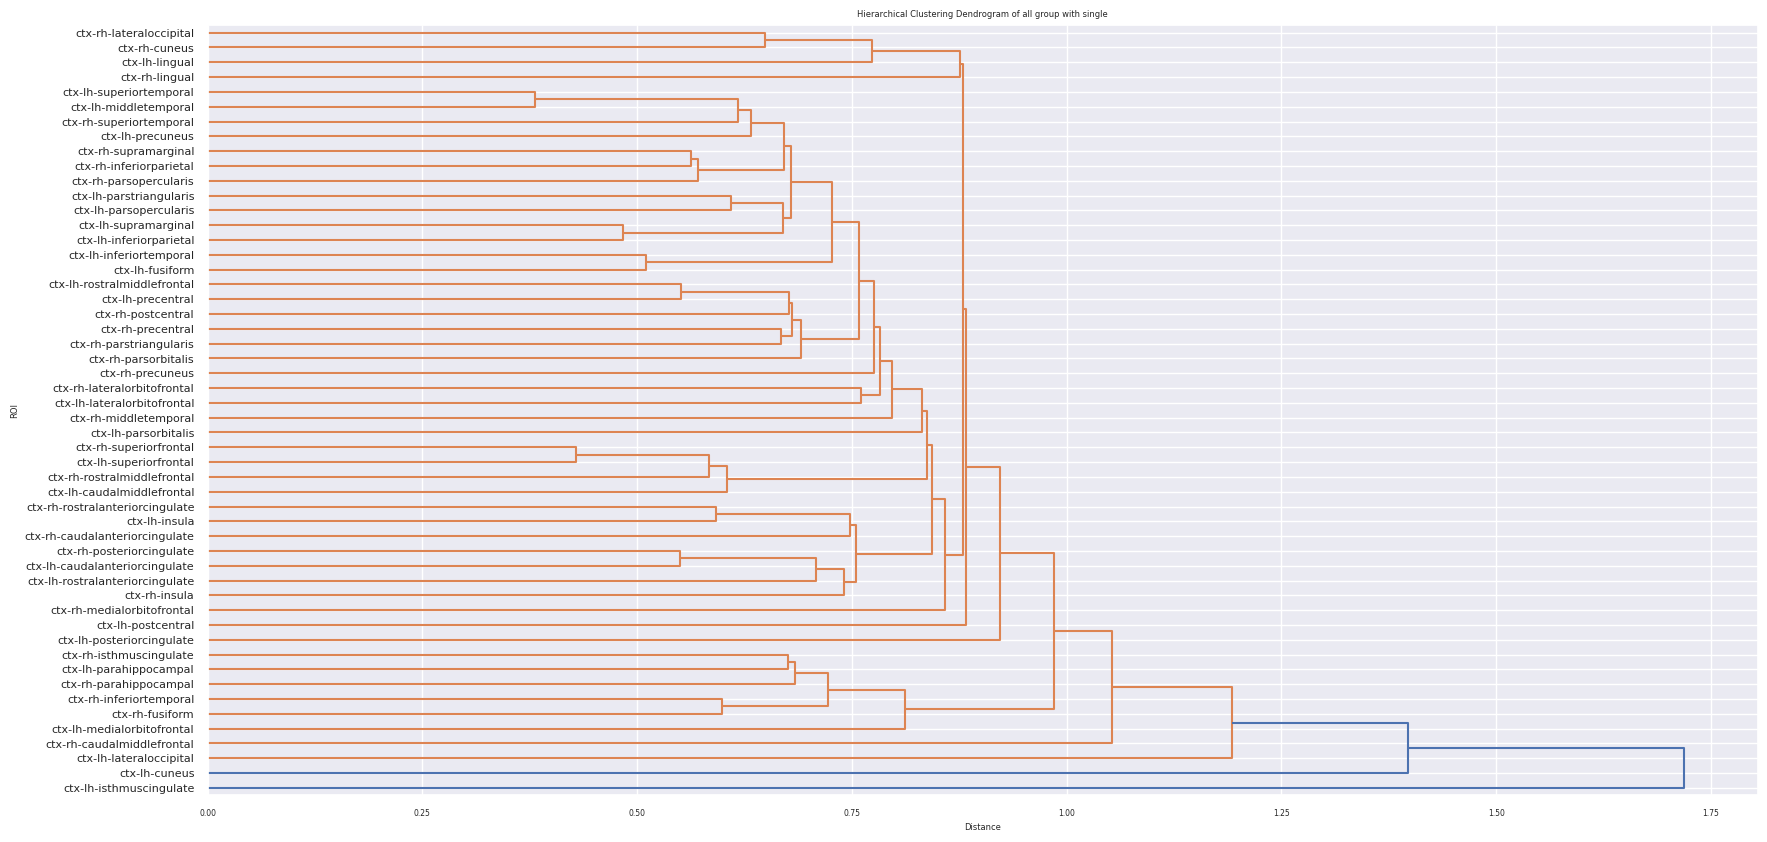

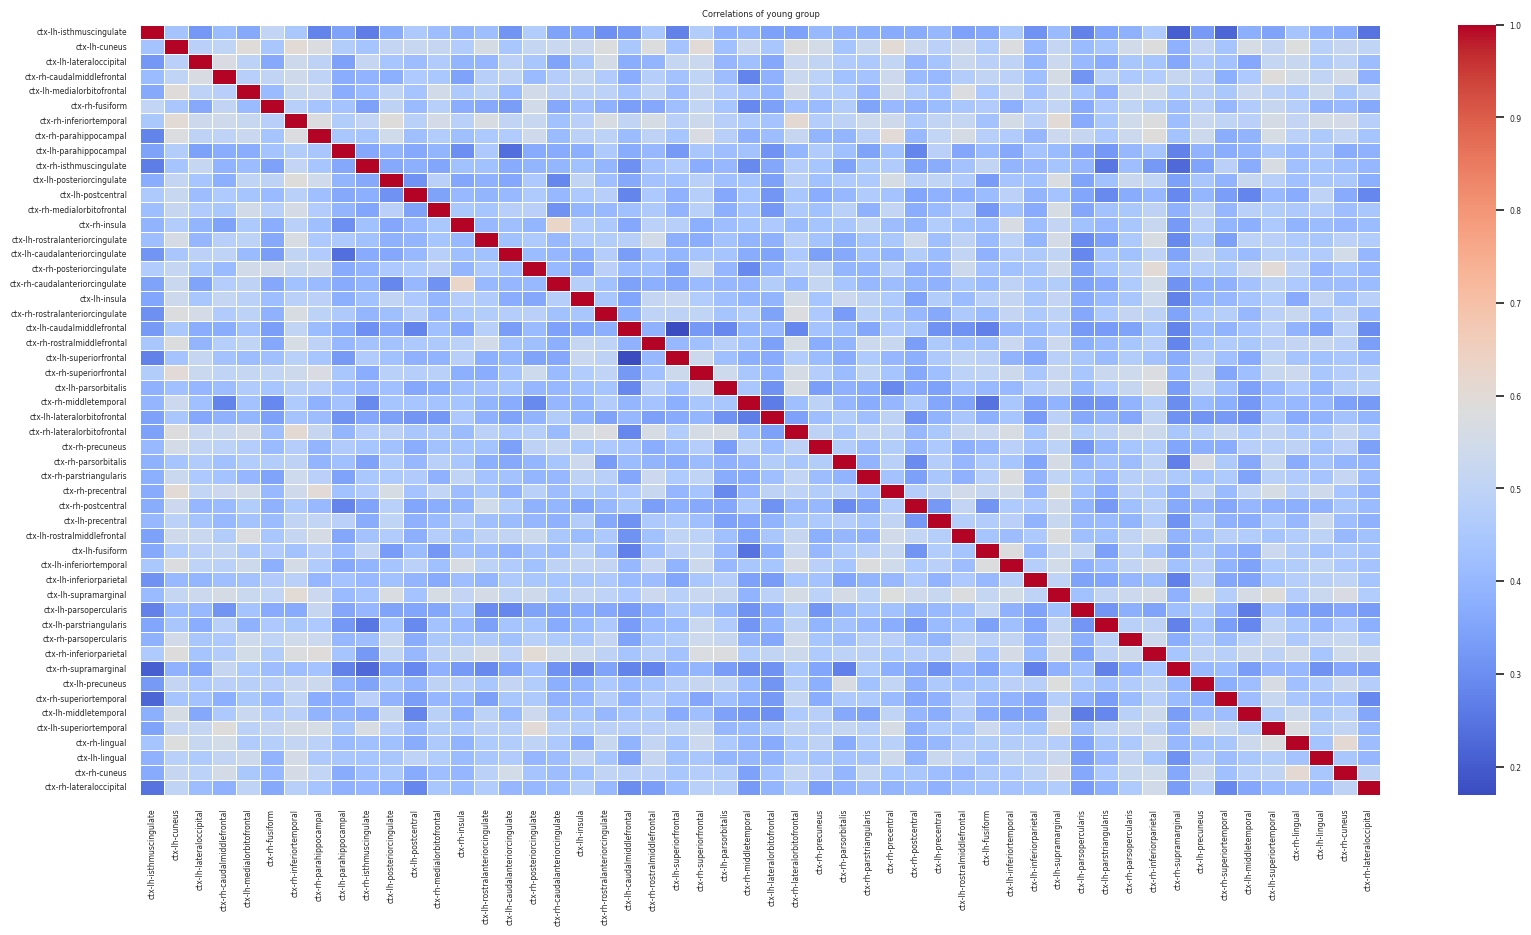

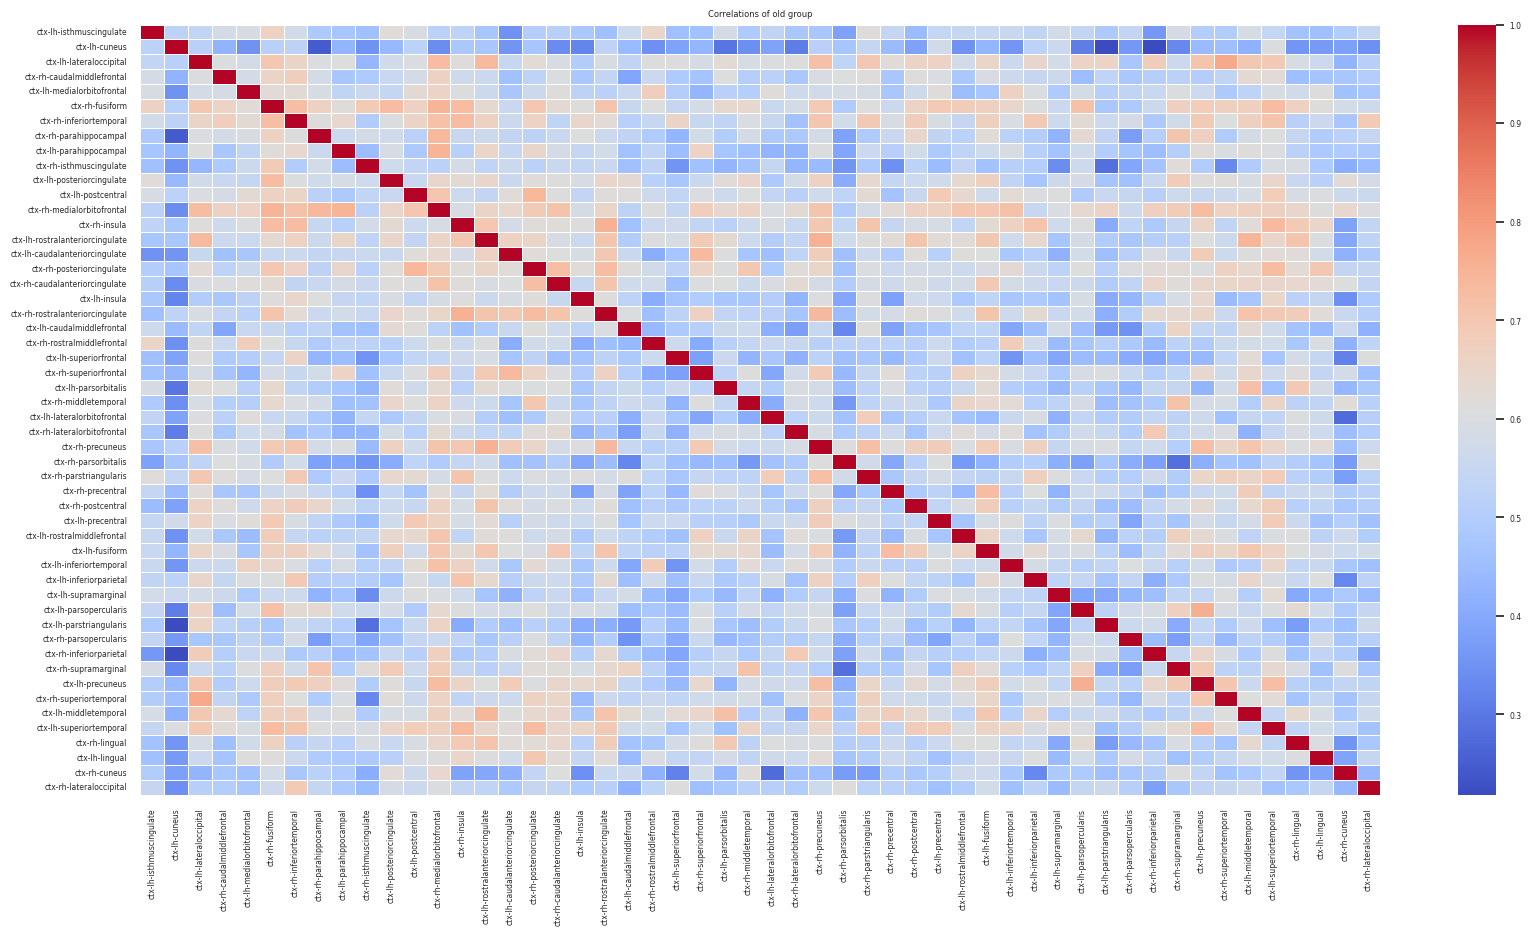

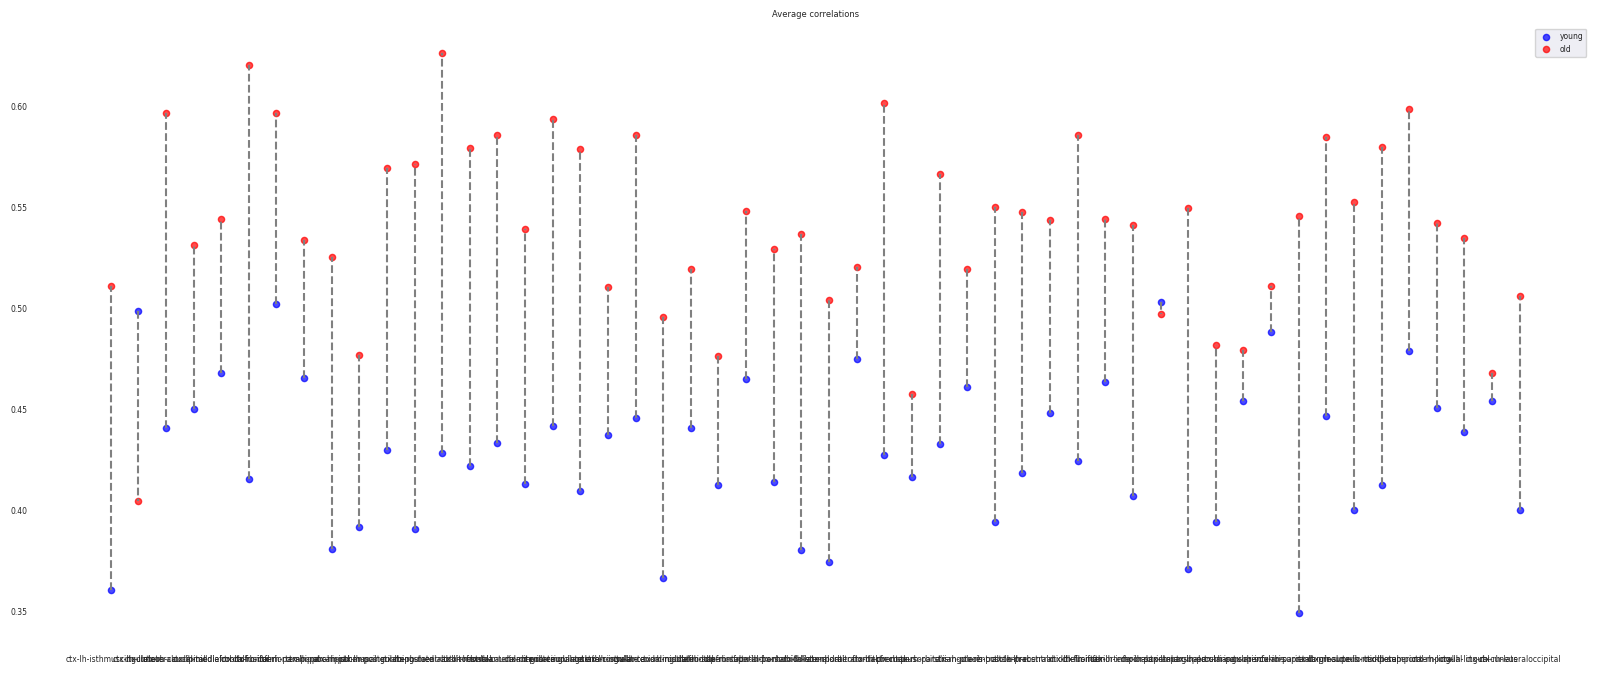

In [89]:
show_correlations_stats(chosen_data_z_score, young_fake_data, old_fake_data, 'pearson')

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:534: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


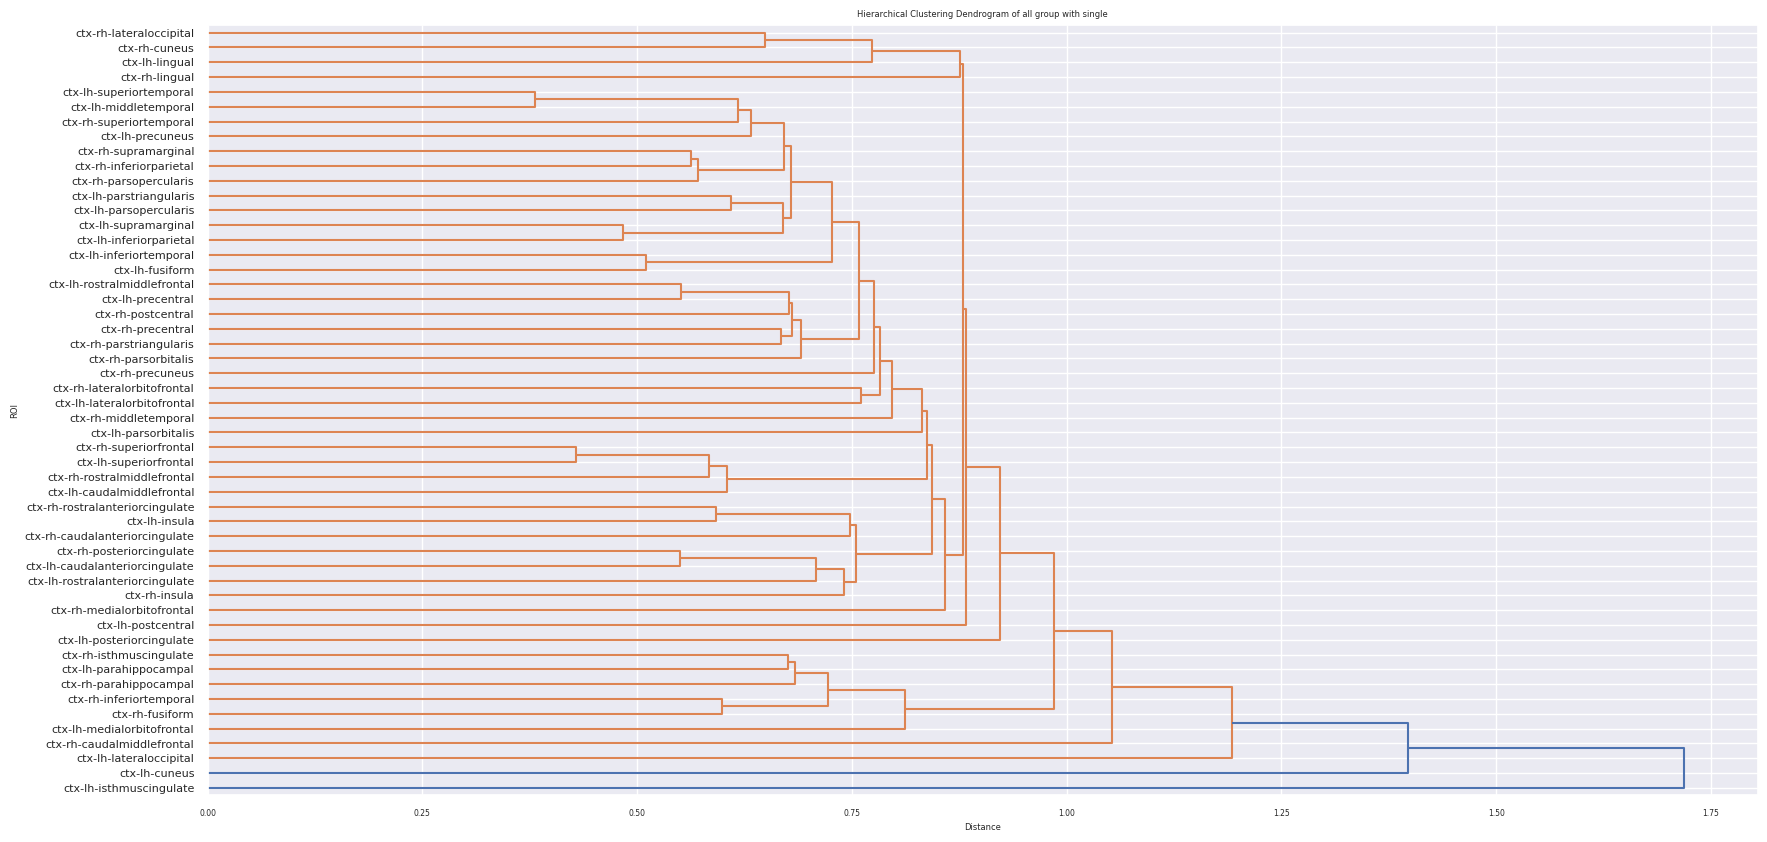

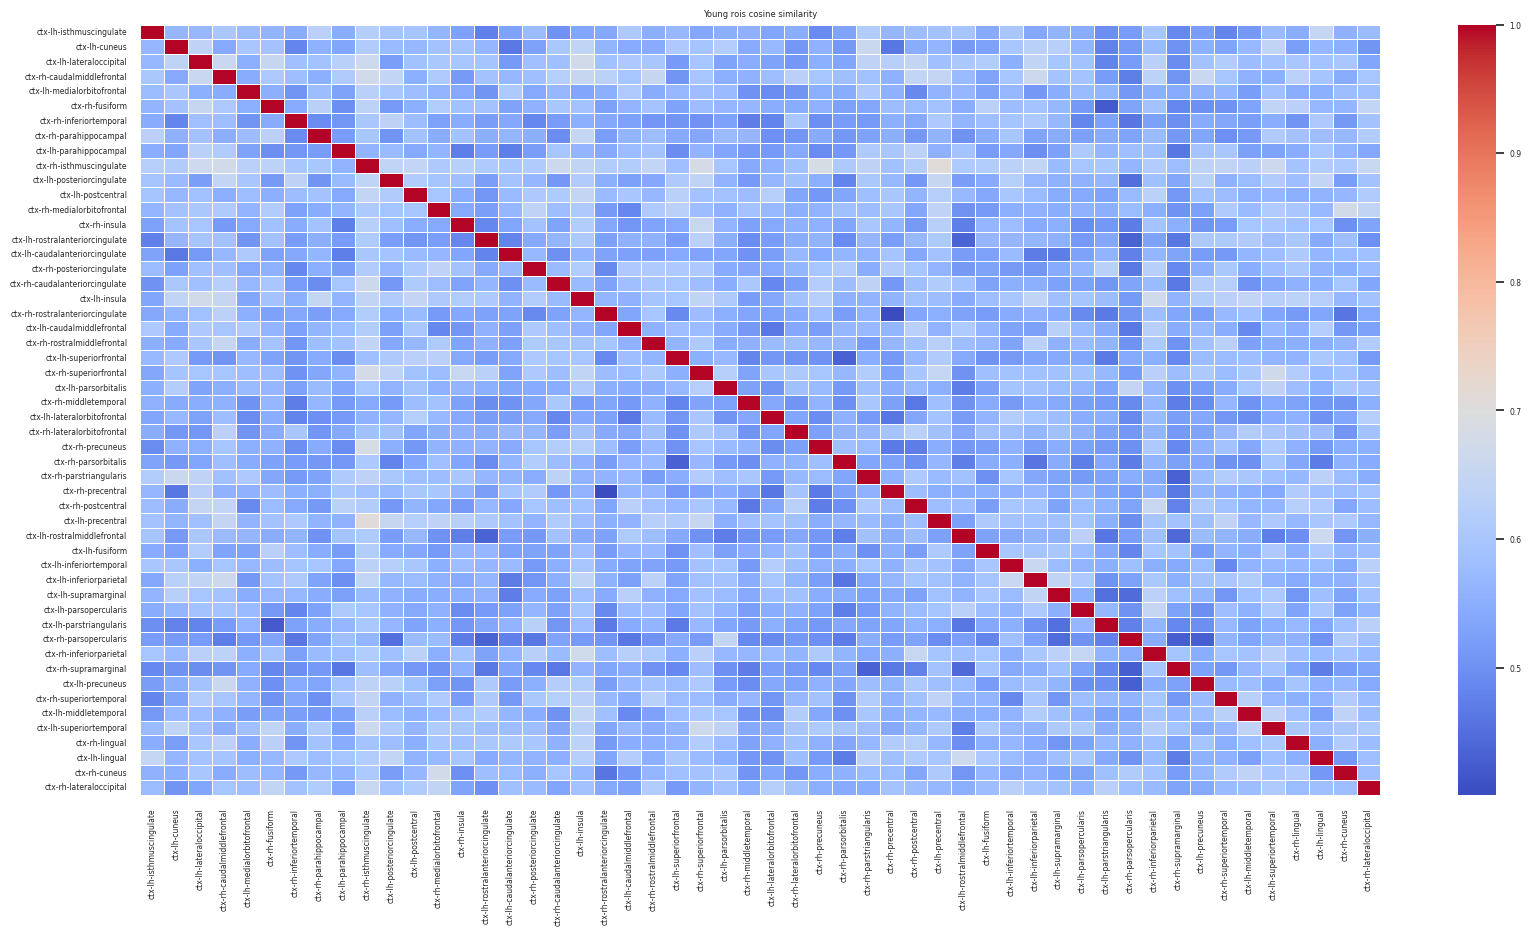

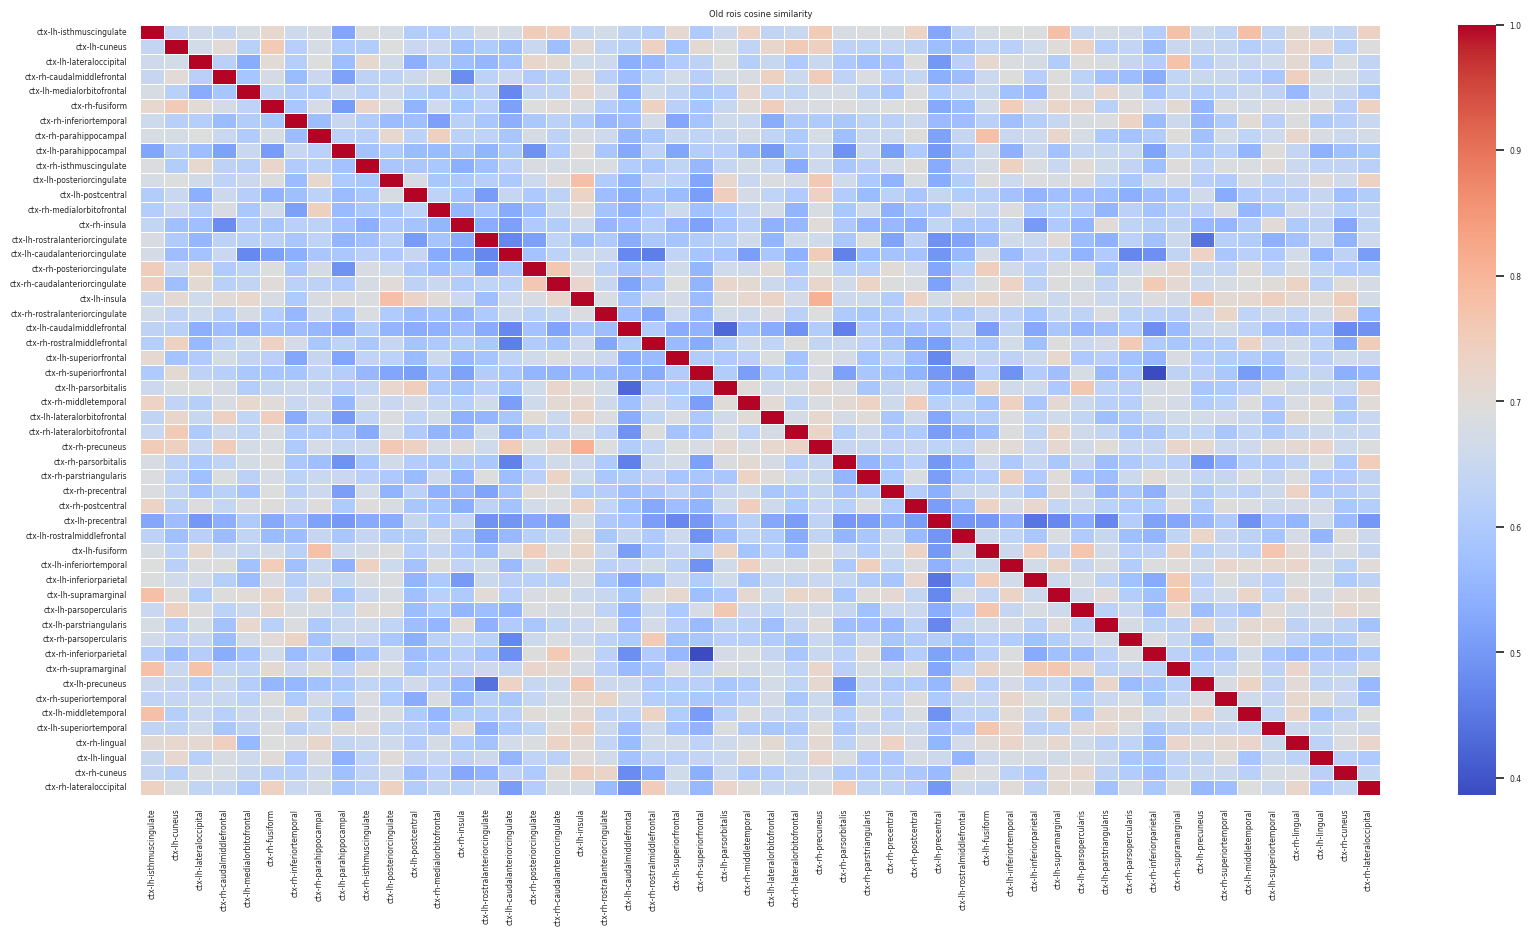

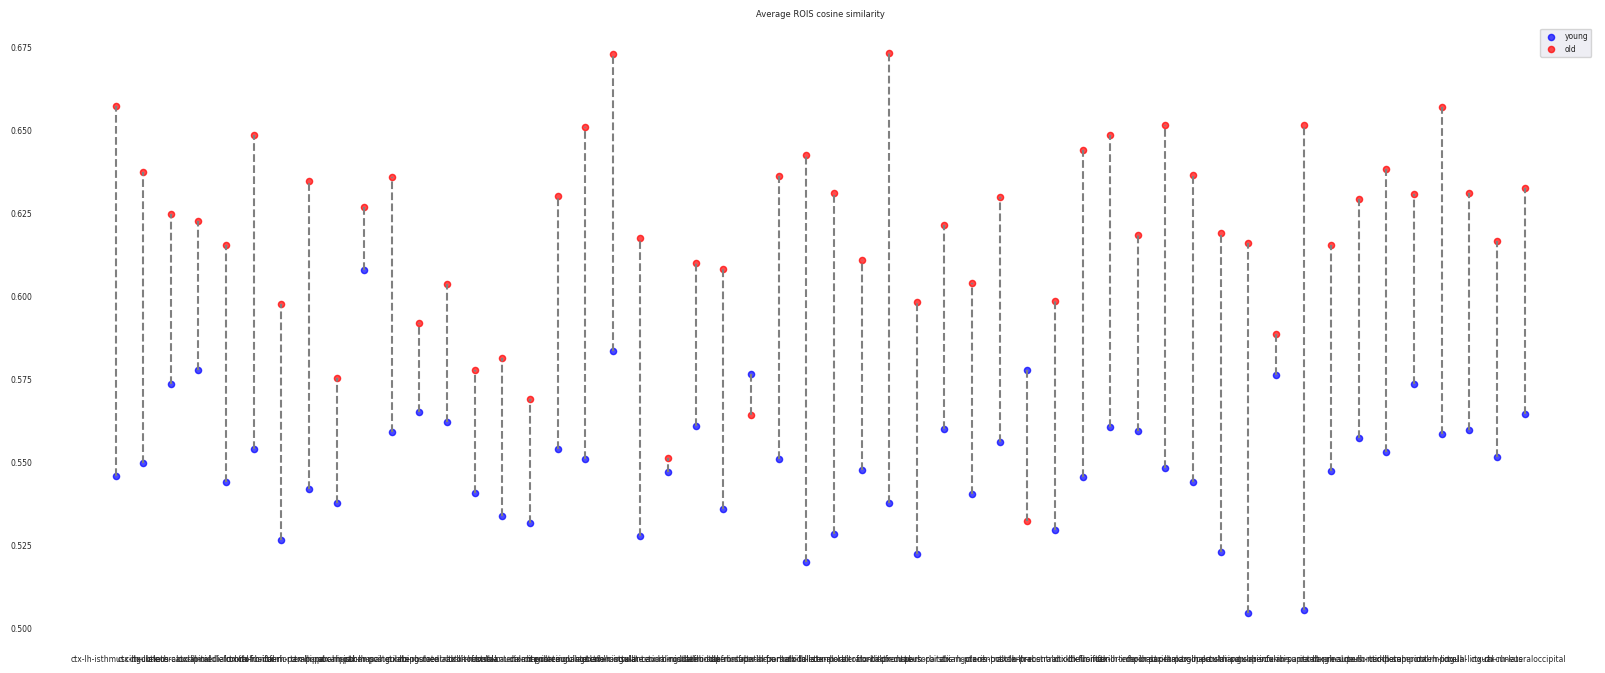

In [79]:
show_distances(cosine_similarity, params_to_work_with, chosen_data_z_score, young_fake_data, old_fake_data, 'cosine similarity')